In [1]:
# typical libraries...
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# for importing and working with texts
import requests
import re
import string

# pytorch stuff
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install torchinfo # not installed by default in colab
from torchinfo import summary

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Create a dataLoader to train the model

In [2]:
# get the raw text from internet (The Time Machine)

text = requests.get('https://www.gutenberg.org/files/35/35-0.txt').text
# character strings to replace with space
strings2replace = [ '\r\n\r\nâ\x80\x9c','â\x80\x9c','â\x80\x9d','\r\n','â\x80\x94','â\x80\x99','â\x80\x98','_', ]

In [3]:
# use regular expression (re) to replace those strings with space
for str2match in strings2replace:
  text = re.compile(r'%s'%str2match).sub(' ',text)

# remove non-ASCII characters and numbers, and make lower-case
text = re.sub(r'[^\x00-\x7F]+', ' ', text)
text = re.sub('\d+','',text).lower()

# split into words with >1 letter
words = re.split(f'[{string.punctuation}\s]+',text)
words = [item.strip() for item in words if item.strip()]
words = [item for item in words if len(item)>1]

<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1456537659.py:7: SyntaxWarning: invalid escape sequence '\d'
  text = re.sub('\d+','',text).lower()
/tmp/ipython-input-1456537659.py:10: SyntaxWarning: invalid escape sequence '\s'
  words = re.split(f'[{string.punctuation}\s]+',text)


In [4]:
# Create the vocab
vocab = sorted(set(words))
nWords = len(words)
nVocab = len(vocab)


# encoder/decoder look-up-tables (as Python dictionaries)
word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for i,w in enumerate(vocab)}

print(f'The book contains {nWords:,} words, {nVocab:,} of which are unique and comprise the vocab.')
print(f'\n\nFirst 10 vocab words:\n',list(word2idx.keys())[:10])

The book contains 30,698 words, 4,589 of which are unique and comprise the vocab.


First 10 vocab words:
 ['abandon', 'abandoned', 'able', 'abnormally', 'abominable', 'abominations', 'about', 'above', 'abruptly', 'absence']


In [5]:
# parameters for dataset
context_length = 8
stride = 2

#initialize
inputs = []
targets = []

#overlapping sequences of context_length
for i in range(0,nWords-context_length,stride):

  # get a few words
  in_seq = words[i : i+context_length]
  targ_seq = words[i+1 : i+context_length+1]

  #append to list
  inputs.append([word2idx[w] for w in in_seq])
  targets.append([word2idx[w] for w in targ_seq])

print(inputs[123])
print(targets[123])

[1342, 4304, 4119, 342, 4296, 3388, 1474, 131]
[4304, 4119, 342, 4296, 3388, 1474, 131, 209]


In [6]:
# a closer look:
print('Inputs: ',inputs[4])
print('Targets:',targets[4])
print('')
print('Inputs :',inputs[5])
print('Targets:',targets[5])
# this is what we need, although we need it in torch Dataset/DataLoader format

Inputs:  [2416, 131, 2172, 506, 4451, 783, 2167, 2005]
Targets: [131, 2172, 506, 4451, 783, 2167, 2005, 4042]

Inputs : [2172, 506, 4451, 783, 2167, 2005, 4042, 2416]
Targets: [506, 4451, 783, 2167, 2005, 4042, 2416, 2006]


In [7]:
# we need each list to be a tensor
torch.tensor(inputs[4])

tensor([2416,  131, 2172,  506, 4451,  783, 2167, 2005])

In [8]:
# create a class for dataset
class WordDataset(Dataset):
  def __init__(self,text,word2idx,context_length=8,stride=4):

    #initialize
    self.inputs = []
    self.targets = []
    self.word2idx = word2idx

    #overlapping sequence of context_length
    for i in range(0,len(text)-context_length,stride):

      # get a few words
      in_seq   = text[i : i+context_length]
      targ_seq = text[i+1 : i+context_length+1]

      # append to the lists
      self.inputs.append(torch.tensor([word2idx[w] for w in in_seq]))
      self.targets.append(torch.tensor([word2idx[w] for w in targ_seq]))

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]




In [9]:
# create an instance
context_length = 6
stride = 3
text_dataset = WordDataset(words,word2idx,context_length,stride)

text_dataset[4]

(tensor([4451,  783, 2167, 2005, 4042, 2416]),
 tensor([ 783, 2167, 2005, 4042, 2416, 2006]))

In [10]:
# Create the dataloader
dataloader = DataLoader(text_dataset, batch_size=32,shuffle=True,drop_last=True)

# let's have a look at the indices
X,y = next(iter(dataloader))
print('Inputs:')
print(X), print('')

print('Targets:')
print(y), print('\n\n\n')

# and the words
print('Inputs in words (first batch):')
print([idx2word[item.item()] for item in X[0]])
print('')

print('Targets in words (first batch):')
print([idx2word[item.item()] for item in y[0]])

Inputs:
tensor([[ 280, 1640, 2470,  230, 3738, 2731],
        [2977, 2764, 4043, 2265, 4408, 1322],
        [2812, 4109,  153,  137, 2187, 4437],
        [2731, 2429, 1487,  137, 4047, 1122],
        [3092, 4119, 3559, 4041, 1868, 4408],
        [2024,  506, 4042,  619, 3606, 2731],
        [1694, 4144, 4073, 4058,  348, 4352],
        [  10, 2519,  230, 4581, 3408, 2210],
        [1985, 4408, 3399, 4408,  784, 2486],
        [4042, 4204,  255, 1492, 3056, 1640],
        [3181,  230, 1599, 1902,  737, 4042],
        [ 137, 3831, 1408, 3729,  501,  162],
        [1868, 4408, 2041, 4042, 2507, 2731],
        [2481, 2435, 2780,  134, 1815, 2669],
        [2659, 4051, 4408, 2384, 2157, 2731],
        [1901,  137,  792, 4119, 2426, 1901],
        [1215, 2451, 2731,  457, 3699,  704],
        [4510, 2608, 2974, 3883,  341, 2041],
        [ 137, 3152, 2740, 4510, 4404, 4186],
        [4042,  902, 2661, 2186, 4408, 2685],
        [ 255, 1183, 2778, 4047, 2001,  341],
        [2636,  230, 1929,

#Next:

* create a random embeddings matrix

* calculate cosine similarity between "time" and "machine"

* Build and test the model

* Generate text

* Check Model size

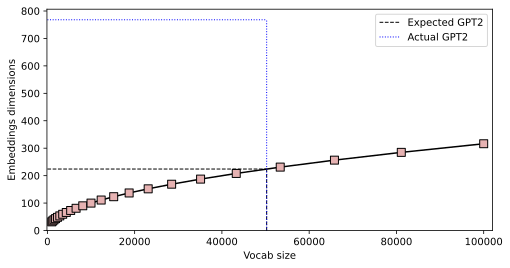

In [11]:
# exploring dimensionality based on vocab sizes

# vocab sizes
N = np.logspace(np.log10(1000),np.log10(100000),23)

# heuristic for non-LLM models like word2vec or glove:
embdim = np.sqrt(N)

# parameters for GPT2
gpt2dims = [ 50257,768 ]

plt.figure(figsize=(8,4))

# heuristic line
plt.plot(N,embdim,'ks-',markersize=8,markerfacecolor=[.9,.7,.7],label=r'')

# expected embedding dim for GPT2
plt.plot([gpt2dims[0],gpt2dims[0]],[0,np.sqrt(gpt2dims[0])],'k--',linewidth=1,label='Expected GPT2')
plt.plot([0,gpt2dims[0]],[np.sqrt(gpt2dims[0]),np.sqrt(gpt2dims[0])],'k--',linewidth=1)

# actual GPT2 embedding
plt.plot([gpt2dims[0],gpt2dims[0]],[0,gpt2dims[1]],'b:',linewidth=1,label='Actual GPT2')
plt.plot([0,gpt2dims[0]],[gpt2dims[1],gpt2dims[1]],'b:',linewidth=1)

plt.gca().set(xlabel='Vocab size',ylabel='Embeddings dimensions',
              xlim=[-100,N[-1]+2000],ylim=[0,None])
plt.legend()
plt.show()

In [12]:
### Show how embeddings work

# dimensionality of embedding space (arebitrarily set to 100)
embeddingDimension = 100

# create a random embedding
embedding_layer = nn.Embedding(nVocab,embeddingDimension)

# see sizes
print(f'Size of Vocab: {nVocab}')
print(f'Size of Embedding: {embedding_layer.weight.shape}')

Size of Vocab: 4589
Size of Embedding: torch.Size([4589, 100])


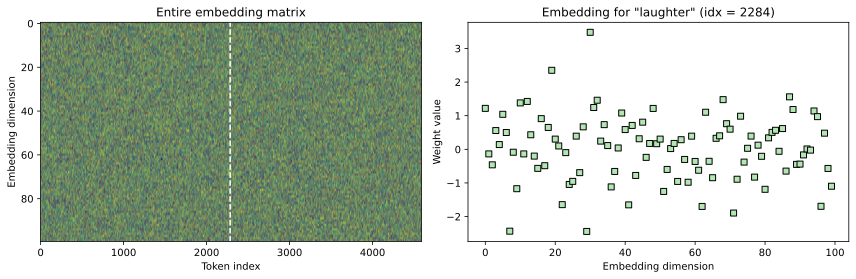

In [13]:
# what does it look like?

_,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].imshow(embedding_layer.weight.detach().T,aspect='auto',vmin=-1,vmax=1)
axs[0].set(ylabel='Embedding dimension',xlabel='Token index',title='Entire embedding matrix')

# pick a word at random
aRandomWord = np.random.choice(vocab)

# plot its embedding
axs[1].plot(embedding_layer.weight.detach()[word2idx[aRandomWord],:],'ks',markerfacecolor=[.7,.9,.7])
axs[0].axvline(word2idx[aRandomWord],color='w',linestyle='--')
axs[1].set(xlabel='Embedding dimension',ylabel='Weight value',title=f'Embedding for "{aRandomWord}" (idx = {word2idx[aRandomWord]})')

plt.tight_layout()
plt.show()

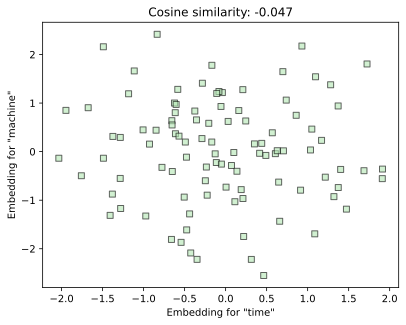

In [14]:
# embeddings for closely related words
word1 = 'time'
word2 = 'machine'

# their embeddings
embed1 = embedding_layer.weight.detach()[word2idx[word1],:]
embed2 = embedding_layer.weight.detach()[word2idx[word2],:]

# cosine similiarity between them
cosSim = torch.dot(embed1,embed2)/(torch.norm(embed1)*torch.norm(embed2))

# vizualize
plt.plot(embed1,embed2,'ks',markerfacecolor=[.7,.9,.7],alpha=.6)
plt.gca().set(xlabel=f'Embedding for "{word1}"',ylabel=f'Embedding for "{word2}"',
              title=f'Cosine similarity: {cosSim:.3f}')
plt.show()

In [15]:
# embedding Model

class EmbeddingsModel(nn.Module):
  def __init__(self,vocab_size, embedding_dim, context_size):
    super(EmbeddingsModel,self).__init__()

    #embedding layer
    self.embeddings = nn.Embedding(vocab_size,embedding_dim)

    # Linear layers
    self.linear1 = nn.Linear(context_size*embedding_dim,128)
    self.linear2 = nn.Linear(128,vocab_size)

  def forward(self,inputs):

    # extract and flatten embeddings [batch_size, context_size * embeddin_dim]
    embeds = self.embeddings(inputs).view(inputs.shape[0],-1)

    #fully connected layer
    out = F.relu(self.linear1(embeds))
    out = self.linear2(out)

    # log softmax for classification (note: NLLoss expects logprobs as inputs)
    log_probs = F.log_softmax(out,dim=1)
    return log_probs



In [16]:
#Create a model
model = EmbeddingsModel(nVocab, embeddingDimension,context_length)
print(model)

EmbeddingsModel(
  (embeddings): Embedding(4589, 100)
  (linear1): Linear(in_features=600, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=4589, bias=True)
)


In [17]:
#apply Xavier weight distribution
for param in model.parameters():
  if param.dim()>1:
    nn.init.xavier_normal_(param)

In [18]:
X,y = next(iter(dataloader))
modelOut = model(X)

print('Input to model:')
print(X), print('')

print(f'Output from model (size: {list(modelOut.detach().shape)}):')
print(modelOut)

Input to model:
tensor([[3468, 2041, 1570, 4158, 4428, 3798],
        [1619, 3250, 3375, 4366, 2041,  137],
        [2041, 2851, 4454, 4352, 3721,  538],
        [1811,  137, 2125,  204, 4308, 4051],
        [4092, 4042,  472, 1608,  137, 4295],
        [4042,  387, 4000, 2731,  497, 3152],
        [4295, 4042, 1918, 4466, 1815, 1554],
        [1919, 2764, 4209, 3950,  506, 3431],
        [2163, 4584, 1631, 1390,  137, 4013],
        [1153,  102, 4042, 4109, 1036, 2764],
        [2685, 1894, 2609, 2281,  103, 1739],
        [4463, 2509, 3636, 4510, 4041, 3225],
        [ 184, 4042, 1216, 2731, 4042, 3933],
        [3452, 2897,  230,  131, 1214, 2731],
        [2608, 4109, 2416, 2509, 3917, 3292],
        [1929, 1694, 4408, 2947, 1275, 4042],
        [ 137, 1763, 2331, 2933, 1773, 1385],
        [2855, 4042, 2659, 4296, 4042, 2750],
        [1572, 1868, 2387, 3363, 4042, 3987],
        [1095,  371, 4042, 1587, 4086, 1039],
        [4408, 1902, 4041, 4408,  995,  255],
        [2186, 335

In [19]:

# log soft-max output:
print(modelOut.detach()[0])
print('')

# shouldn't the sum be 1?
print(f'Log softmax sum = {modelOut.detach()[0].sum():.3f}')

# ah, it's *log* softmax :D
print(f'exp(log(softmax)) sum = {torch.exp(modelOut.detach()[0]).sum():.3f}')

tensor([-8.3713, -8.5167, -8.3514,  ..., -8.4990, -8.3821, -8.4683])

Log softmax sum = -38697.832
exp(log(softmax)) sum = 1.000


In [20]:
# find the word with the highest probability
print('Model input:')
print([idx2word[w.item()] for w in X[0]])
print('')

print('Model output:')
print(idx2word[modelOut[0].argmax().item()])

Model input:
['seen', 'in', 'footsore', 'tramps', 'we', 'stared']

Model output:
gusts


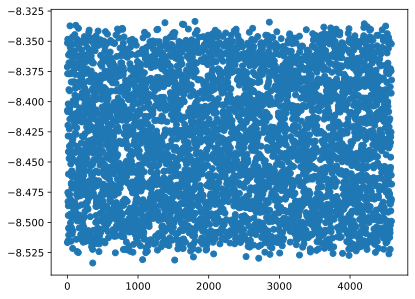

In [21]:
plt.plot(modelOut[0].detach(),'o');

In [22]:
# grab some data from the loader
X,y = next(iter(dataloader))

print('First input:')
print(' '.join([idx2word[w.item()] for w in X[0]]))
print('\nSubsequent inputs:')

# text generation
for _ in range(context_length):

  # get output for this input
  Y = model(X)

  # pick the most likely next word
  nextWord = Y[0].argmax().item()

  # create new input for the next iteration (word)
  X[0] = torch.concatenate((X[0][1:],torch.tensor([nextWord])))

  # print out the generated text so far
  print(' '.join([idx2word[w.item()] for w in X[0]]))

First input:
look the stained glass windows which

Subsequent inputs:
the stained glass windows which exultation
stained glass windows which exultation intense
glass windows which exultation intense gusts
windows which exultation intense gusts consumptive
which exultation intense gusts consumptive luxurious
exultation intense gusts consumptive luxurious hanged


In [23]:
# summary of model and parameters
summary(model, input_data=X, col_names=['input_size','output_size','num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
EmbeddingsModel                          [32, 6]                   [32, 4589]                --
├─Embedding: 1-1                         [32, 6]                   [32, 6, 100]              458,900
├─Linear: 1-2                            [32, 600]                 [32, 128]                 76,928
├─Linear: 1-3                            [32, 128]                 [32, 4589]                591,981
Total params: 1,127,809
Trainable params: 1,127,809
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 36.09
Input size (MB): 0.00
Forward/backward pass size (MB): 1.36
Params size (MB): 4.51
Estimated Total Size (MB): 5.87

In [24]:
# use the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
# create a fresh model instance
model = EmbeddingsModel(vocab_size=nVocab, embedding_dim=embeddingDimension, context_size=context_length)

# with Xavier weight distribution
for param in model.parameters():
  if param.dim()>1: nn.init.xavier_normal_(param)


# and move it to the GPU
model = model.to(device)

In [26]:
loss_function = nn.NLLLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=.001, weight_decay=.01)

In [27]:
# quick test for errors and sanity-check the output matrix sizes
X,y = next(iter(dataloader))
X,y = X.to(device), y.to(device)

# forward pass
modelOutput = model(X)

# check the sizes
print(f'Model input is of size: {X.shape}')
print(f'Target output is of size: {y.shape}')
print(f'Model output is of size: {modelOutput.shape}')

# loss function
loss = loss_function(modelOutput,y[:,-1])
print(f'\nLoss:')
loss


Model input is of size: torch.Size([32, 6])
Target output is of size: torch.Size([32, 6])
Model output is of size: torch.Size([32, 4589])

Loss:


tensor(8.4132, device='cuda:0', grad_fn=<NllLossBackward0>)

In [28]:
# extract a copy of the pretrained embedding weights for comparison later
pretrained_embeddings = model.embeddings.weight.detach().cpu().clone()

In [29]:
def trainTheModel(model,num_epochs=25):

  # initialize losses
  total_loss = np.zeros(num_epochs)

  for epoch in range(num_epochs):

    # initialize
    epoch_loss = 0

    # loop over batches in the data loader
    for X,y in dataloader:

      # move data to GPU
      X,y = X.to(device), y.to(device)

      # clear previous gradients
      model.zero_grad()

      # forward pass
      log_probs = model(X)

      # calculate the losses from the final target word
      loss = loss_function(log_probs,y[:,-1])

      # backprop
      loss.backward()
      optimizer.step()

      # sum the per-epoch losses
      epoch_loss += loss.item()

    # scale by the number of tokens in this dataloader
    total_loss[epoch] = epoch_loss / len(dataloader.dataset)

    # update our progress :)
    print(f'  Finished epoch {epoch+1} with loss {epoch_loss / len(dataloader.dataset):.4f}')

  # output the model and the losses
  return model,total_loss

  Finished epoch 1 with loss 0.2172
  Finished epoch 2 with loss 0.1882
  Finished epoch 3 with loss 0.1756
  Finished epoch 4 with loss 0.1648
  Finished epoch 5 with loss 0.1549
  Finished epoch 6 with loss 0.1446
  Finished epoch 7 with loss 0.1330
  Finished epoch 8 with loss 0.1195
  Finished epoch 9 with loss 0.1042
  Finished epoch 10 with loss 0.0868
  Finished epoch 11 with loss 0.0680
  Finished epoch 12 with loss 0.0486
  Finished epoch 13 with loss 0.0305
  Finished epoch 14 with loss 0.0170
  Finished epoch 15 with loss 0.0088
  Finished epoch 16 with loss 0.0045
  Finished epoch 17 with loss 0.0025
  Finished epoch 18 with loss 0.0014
  Finished epoch 19 with loss 0.0009
  Finished epoch 20 with loss 0.0007
  Finished epoch 21 with loss 0.0006
  Finished epoch 22 with loss 0.0004
  Finished epoch 23 with loss 0.0003
  Finished epoch 24 with loss 0.0003
  Finished epoch 25 with loss 0.0002


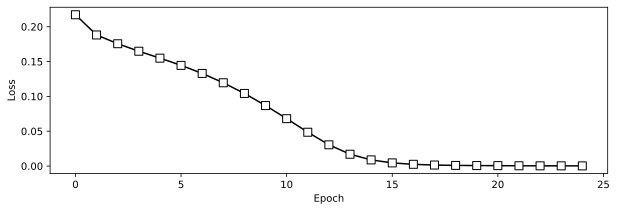

In [30]:
# train the model!
model,total_loss = trainTheModel(model) # using default 25 epochs

# plot the losses
plt.figure(figsize=(10,3))
plt.plot(total_loss,'ks-',markerfacecolor='w',markersize=8)
plt.gca().set(xlabel='Epoch',ylabel='Loss')
plt.show()

In [31]:
# get a copy of the trained weights
postrained_embeddings = model.embeddings.weight.detach().cpu().clone()

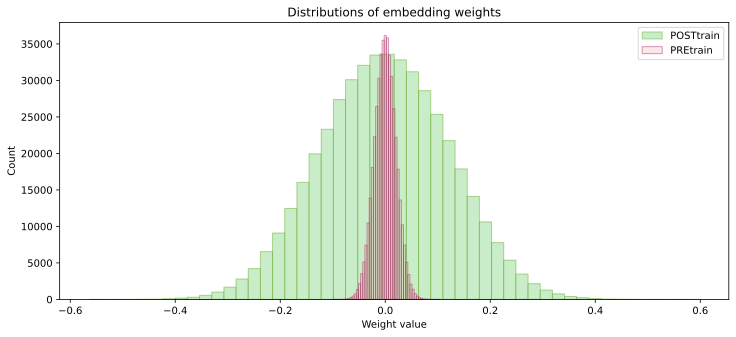

In [32]:
# histograms via numpy
yPre,xPre = np.histogram(pretrained_embeddings.flatten(),bins=50)
yPst,xPst = np.histogram(postrained_embeddings.flatten(),bins=50)

# recalculate x values as bin centers
xPre = (xPre[1:]+xPre[:-1]) / 2
xPst = (xPst[1:]+xPst[:-1]) / 2

# and plot
plt.figure(figsize=(12,5))
plt.bar(xPst,yPst,width=xPst[1]-xPst[0],color=[.7,.9,.7,.7],edgecolor=[.3,.6,0,.4],label='POSTtrain')
plt.bar(xPre,yPre,width=xPre[1]-xPre[0],color=[.9,.7,.7,.3],edgecolor=[.6,0,.3,.4],label='PREtrain')

plt.gca().set(xlabel='Weight value',ylabel='Count',title='Distributions of embedding weights')
plt.legend()
plt.show()

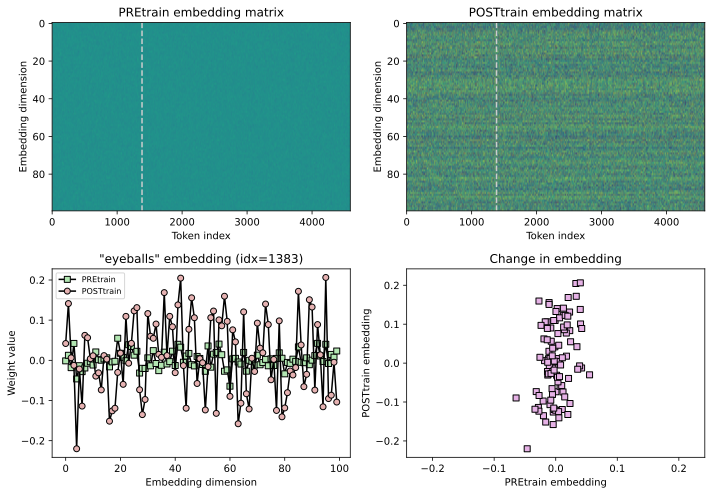

In [33]:
# pick a word at random
aRandomWord = np.random.choice(vocab)
randWord_idx = word2idx[aRandomWord]

# extract its embeddings vectors
pre_ev = pretrained_embeddings[randWord_idx,:]
pst_ev = postrained_embeddings[randWord_idx,:]



_,axs = plt.subplots(2,2,figsize=(10,7))

# the pretrainined embeddings
axs[0,0].imshow(pretrained_embeddings.T,aspect='auto',vmin=-.2,vmax=.2)
axs[0,0].set(ylabel='Embedding dimension',xlabel='Token index',title='PREtrain embedding matrix')

# the post-trainined embeddings
axs[0,1].imshow(postrained_embeddings.T,aspect='auto',vmin=-.2,vmax=.2)
axs[0,1].set(ylabel='Embedding dimension',xlabel='Token index',title='POSTtrain embedding matrix')


axs[0,0].axvline(randWord_idx,linestyle='--',color=[.8,.8,.8])
axs[0,1].axvline(randWord_idx,linestyle='--',color=[.8,.8,.8])

# plot its embedding
axs[1,0].plot(pre_ev,'ks-',markerfacecolor=[.7,.9,.7],label='PREtrain')
axs[1,0].plot(pst_ev,'ko-',markerfacecolor=[.9,.7,.7],label='POSTtrain')
axs[1,0].set(xlabel='Embedding dimension',ylabel='Weight value',title=f'"{aRandomWord}" embedding (idx={randWord_idx})')
axs[1,0].legend(fontsize=8)

# how it changed
axlim = max(abs(pre_ev).max(),abs(pst_ev).max()) * 1.1 # equal axis limits
axs[1,1].plot(pre_ev,pst_ev,'ks',markerfacecolor=[.9,.7,.9])
axs[1,1].set(xlim=[-axlim,axlim],ylim=[-axlim,axlim],xlabel='PREtrain embedding',
             ylabel='POSTtrain embedding',title='Change in embedding')

plt.tight_layout()
plt.show()

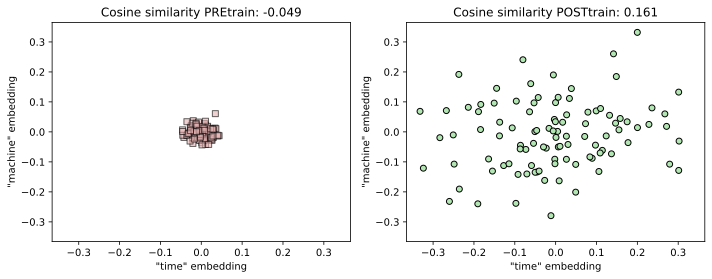

In [34]:
# embeddings for closely related words
word1 = 'time'
word2 = 'machine'

# their embeddings
embed1pre = pretrained_embeddings[word2idx[word1],:]
embed2pre = pretrained_embeddings[word2idx[word2],:]
embed1pst = postrained_embeddings[word2idx[word1],:]
embed2pst = postrained_embeddings[word2idx[word2],:]

# cosine similarity between them
cosSim_pre = F.cosine_similarity(embed1pre.unsqueeze(dim=0),embed2pre.view(1,-1))
cosSim_pst = nn.functional.cosine_similarity(embed1pst.unsqueeze(dim=0),embed2pst.view(1,-1))


# vizualize
_,axs = plt.subplots(1,2,figsize=(10,4))

axlim = torch.cat((abs(embed1pre),abs(embed2pre),abs(embed1pst),abs(embed2pst))).max() * 1.1
axs[0].plot(embed1pre,embed2pre,'ks',markerfacecolor=[.9,.7,.7],alpha=.6)
axs[0].set(xlim=[-axlim,axlim],ylim=[-axlim,axlim],xlabel=f'"{word1}" embedding',
           ylabel=f'"{word2}" embedding',title=f'Cosine similarity PREtrain: {cosSim_pre.item():.3f}')

axs[1].plot(embed1pst,embed2pst,'ko',markerfacecolor=[.7,.9,.7])
axs[1].set(xlim=[-axlim,axlim],ylim=[-axlim,axlim],xlabel=f'"{word1}" embedding',
           ylabel=f'"{word2}" embedding',title=f'Cosine similarity POSTtrain: {cosSim_pst.item():.3f}')

plt.tight_layout()
plt.show()

In [35]:
# cosine similarity manually
num = torch.dot(embed1pst,embed2pst)
den = torch.norm(embed1pst)*torch.norm(embed2pst)
cs_man = num / den

# and via pytorch
cs_pyt = F.cosine_similarity(embed2pst.unsqueeze(dim=0),embed1pst.view(1,-1))

print(f'Cosine similarity from numpy: {cs_man:.4f}')
print(f'Cosine similarity from torch: {cs_pyt.item():.4f}')

Cosine similarity from numpy: 0.1606
Cosine similarity from torch: 0.1606
